# Prova CNC
Prática 1 - Rafael dos Santos

# Bibliotecas a serem importadas

In [2]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

# Bibliotecas implementadas

## Método da Gauss

In [3]:
def gauss(A, B):
    n = len(B)
    B = B.copy()

    # Triangularização
    for k in range(n):
        for i in range(k+1, n):
            m = A[i][k] / A[k][k]
            A[i][k] = 0
            for j in range(k+1, n):
                A[i][j] = A[i][j] - m * A[k][j]
            B[i] = B[i] - m * B[k]

    # Retrosubstituição
    X = [0] * n
    X[n-1] = B[n-1] / A[n-1][n-1]
    for k in range(n-1, -1, -1):
        soma = 0
        for j in range(k+1, n):
            soma += A[k][j] * X[j]
        X[k] = (B[k] - soma) / A[k][k]

    return X;

## Método de Newton-Raphson

In [4]:
def newtonRaphson(x0, ep1, ep2, nMax, funcao, derivada):
	k = 0
	x = x0 - funcao(x0) / derivada(x0)
	while (k < nMax) and (abs(x - x0) > ep1) and (abs(funcao(x)) > ep2):
		x0 = x
		k = k + 1
		x = x0 - funcao(x0) / derivada(x0)
	return x

## Método de Interpolação por Solução de Sistemas de Equações - Vandermonde

In [5]:
def fatorial(x):
    res = 1
    while x > 0:
        res *= x
        x -= 1
    return res

def vandermonde(x, y, ponto = None, funcao = None, derivada = None):
    y_copy = y.copy()
    print("1)......TABELA DE DADOS......:")

    n = len(y)

    for i in range(n):
        print("  x = %.6f; f(x) = %.6f" %(x[i], y[i]))

    matrix = np.zeros([n, n])

    for i in range(n):
        for j in range(n):
            matrix[i][j] = x[i] ** j

    print('\n2)......MATRIZ DE VANDERMONDE DO SISTEMA DE EQUAÇÃO......:')
    for i in range(n):
        for j in range(n):
            print("  %.6f" %matrix[i][j], end="\t")
        print()

    result = gauss(matrix, y)

    print('\n3)......COEFICIENTES DO POLINÔMIO INTERPOLADOR - VANDERMONDE......:')
    for i in range(n):
        print("  a%d = %.6f" %(i, result[i]))

    print('\n4)......POLINÔMIO INTERPOLADOR POR SISTEMA DE EQUAÇÃO......:')

    # Construindo o polinômio utilizando sympy
    simx = sp.Symbol('x')
    polinomio = sum(result[i] * simx**i for i in range(n))

    # Simplificando o polinômio
    polinomio_simplificado = sp.simplify(polinomio)
    print(polinomio_simplificado)

    aprox = None
    if funcao != None:
        print('\n5)......VALORES EXATO, APROX. e ERRO RELATIVO......:')
        y_orig = funcao.subs('x', ponto)
        print("  a) O valor exato em x = \"%f\" é: %.6f" % (ponto, y_orig))

        # Avaliando o polinômio no ponto
        aprox = float(polinomio_simplificado.subs(simx, ponto))

        print("  b) O valor aproximado em x = \"%f\" por Vandermonde é: %.6f" % (ponto, aprox))
        erro_relativo = abs((y_orig - aprox) / y_orig) * 100
        print("  c) O Er_Rel, |(%.6f - %.6f) / %.6f| * 100%% é: %.6f%%" % (y_orig, aprox, y_orig, erro_relativo))
        print("\n6)......ESTIMATIVA DO ERRO DE TRUNCAMENTO......:")

        valor_max_y = abs(derivada.subs('x', x[0]))
        for i in range(1, n):
            cur_deriv = abs(derivada.subs('x', x[i]))
            if cur_deriv > valor_max_y:
                valor_max_y = cur_deriv

        res = 1
        for i in range(0, n):
            res *= (ponto - x[i])

        res = (abs(res) * valor_max_y) / fatorial(n)
        print("  O erro de truncamento pelo corolario 4.1 é: %.6f" % res)

    elif (funcao == None) and (ponto != None):
        # Avaliando o polinômio no ponto x_aprox
        aprox = float(polinomio_simplificado.subs(simx, ponto))
        print("\n5)......VALOR APROXIMADO......:")
        print("  b) O valor aproximado em x = \"%f\" por Vandermonde é: %.6f" % (ponto, aprox))

    print("\n*****************FIM DO MÉTODO DE VANDERMONDE*****************\n")

    ### PLOT DO GRÁFICO ###
    # Converte o polinômio simplificado em uma função utilizável pelo numpy
    polinomio_funcao = sp.lambdify(simx, polinomio_simplificado)

    # Define um intervalo de valores para x para plotar a função
    x_vals = np.linspace(min(x) - 1, max(x) + 1, 500)
    y_vals = polinomio_funcao(x_vals)

    # Plota a função polinomial
    plt.plot(x_vals, y_vals, label=f'Polinômio Interpolador: {polinomio_simplificado}')

    # Plota os pontos de dados originais
    plt.scatter(x, y_copy, color='red', label='Pontos de dados')

    # Plota o ponto de aproximação se o mesmo existir
    if aprox != None:
        plt.plot(ponto, aprox, 'mo', label='Ponto de aproximação')

    # Adiciona grade ao gráfico
    plt.grid(True)

    # Adiciona título e rótulos dos eixos
    plt.title('Gráfico da Função Interpoladora de Vandermonde', fontweight='bold')
    plt.xlabel('X', labelpad=8, fontsize=12, fontweight='bold')
    plt.ylabel('Y', rotation=0, labelpad=20, fontsize=12, fontweight='bold')

    # Adiciona a legenda
    plt.legend()

    # Mostra o gráfico
    plt.show()


## Método de Interpolação de Langrange

In [6]:
def fatorial(x):
    res = 1
    while x > 0:
        res *= x
        x -= 1
    return res

def lagrange(x, y, x_aprox = None, func_original = None, derivada_n = None):
    print('1)......TABELA DE DADOS......:')

    n = len(y)

    for i in range(n):
        print(f"x = {x[i]}; f(x) = {y[i]}")

    xis = np.zeros([0])
    coefs = np.zeros([n, n])

    denom = 1
    for i in range(n):
        for j in range(n):
            if i == j:
                continue

            denom *= x[i] - x[j]
            xis = np.append(xis, x[j])

        over_denom = 1 / denom
        if n == 4:
            xcube = over_denom
            xsquare = -over_denom * (xis[0] + xis[1] + xis[2])
            xfirst = over_denom * (xis[0]*xis[1] + (xis[0] + xis[1]) * xis[2])
            xzero = -over_denom * (xis[0] * xis[1] * xis[2])

            coefs[i] = [xzero, xfirst, xsquare, xcube]
        elif n == 3:
            xsquare = over_denom
            xfirst = -over_denom * (xis[0] + xis[1])
            xzero = over_denom * (xis[0] * xis[1])

            coefs[i] = [xzero, xfirst, xsquare]
        else:
            xfirst = over_denom
            xzero = -over_denom * xis[0]
            coefs[i] = [xzero, xfirst]

        xcube = xsquare = xfirst = xzero = 0
        denom = 1
        xis = np.zeros([0])

    result = np.zeros([n])

    print('\n2)......COEFICIENTES DE LAGRANGE......:')
    for i in range(n):
        print(f"L{i}(x) = ", end="")
        first_term = True
        for j in range(n):
            if coefs[i][j] != 0:
                if not first_term:
                    if coefs[i][j] > 0:
                        print(f" + ", end="")
                    else:
                        print(f" - ", end="")
                else:
                    first_term = False
                    if coefs[i][j] < 0:
                        print(f"-", end="")

                if j == 0 or abs(coefs[i][j]) != 1:
                    print(f"{abs(coefs[i][j]):.6g}", end="")
                if j > 0:
                    print(f"x^{j}", end="")
        print()

    for i in range(n):
        for j in range(n):
            coefs[i][j] = coefs[i][j] * y[i]

    for i in range(n):
        for j in range(n):
            result[i] += coefs[j][i]

    print('\n3)......POLINÔMIO INTERPOLADOR POR LAGRANGE......:')

    simbolo_x = sp.Symbol('x')

    simp = sum(result[i] * simbolo_x**i for i in range(n))

    simp = sp.simplify(simp)

    print(simp)

    polinomio_funcao = sp.lambdify(simbolo_x, simp)

    print('\n4)......VALORES EXATO, APROX e ERRO RELATIVO......:')

    if func_original is not None and x_aprox is not None:
        y_orig = func_original.subs('x', x_aprox).evalf()
        print(f"a) O valor exato em x = \"{x_aprox:.6f}\" é: {y_orig:.6f}")
    else:
        print("a) Nao temos o valor exato para descobrirmos o valor exato")

    if x_aprox is not None:
        y_aprox = polinomio_funcao(x_aprox)
        print(f"b) O valor aproximado em x = \"{x_aprox:.6f}\" por Lagrange é: {y_aprox:.6f}")
        if func_original is not None:
            calc = ((y_orig - y_aprox)/y_orig) * 100
            print(f"c) O Er_Rel, |{y_orig:.6f} - {y_aprox:.6f}| / {y_orig:.6f}| * 100% é {calc:.6f}%")
        else:
            print("c) Nao temos o valor exato para descobrirmos o erro")

    print("\n5)......ESTIMATIVA DO ERRO DE TRUNCAMENTO......:")

    if func_original is not None:
        valor_max_y = abs(derivada_n.subs('x', x[0]).evalf())
        for i in range(1, n):
            cur_deriv = abs(derivada_n.subs('x', x[i]).evalf())

            if cur_deriv > valor_max_y:
                valor_max_y = cur_deriv

        res = 1
        for i in range(0, n):
            res *= (x_aprox - x[i])

        res = (abs(res) * valor_max_y) / fatorial(n)

        print(f"O erro de truncamento pelo corolário 4.1 é {res:.6f}")
    else:
        print("a) Nao temos a funcao original para descobrirmos o erro")

    print("\n**********FIM DO MÉTODO DE LAGRANGE**********\n")

    x_vals = np.linspace(min(x) - 1, max(x) + 1, 500)
    y_vals = polinomio_funcao(x_vals)

    plt.plot(x_vals, y_vals, label=f'Polinômio Interpolador: {simp}')

    plt.scatter(x, y, color='red', label='Pontos de dados')

    if x_aprox is not None:
        plt.plot(x_aprox, y_aprox, 'mo', label='Ponto de aproximação')

    plt.grid(True)

    plt.title('Gráfico da Função Interpoladora de Lagrange', fontweight='bold')
    plt.xlabel('X', labelpad=8, fontsize=12, fontweight='bold')
    plt.ylabel('Y', rotation=0, labelpad=20, fontsize=12, fontweight='bold')

    plt.legend()

    plt.show()


## Método de Intepolação de Newton


In [7]:
def calcordem(x, y):
    ordem = len(x)
    o = np.zeros(ordem)
    arr = np.zeros(ordem)
    dd = np.zeros((ordem,ordem))

    # Para ordem 0
    for i in range(ordem):
        o[i] = y[i]
        dd[i][0] = y[i]
    arr[0] = y[0]

    # Para ordem maior que 0
    for i in range(1, ordem):
        for j in range(ordem - i):
            o[j] = (o[j+1] - o[j]) / (x[i+j] - x[j])
            dd[j][i] = o[j]
            if j == 0:
                arr[i] = o[j]

    # Para arredondar os numeros
    for i in range(ordem):
        arr[i] = round(arr[i], 6)

    return arr,dd

def fatorial(x):
    res = 1
    while x > 0:
        res *= x
        x -= 1
    return res

def newton(x, y, xtotal = None, ytotal = None, ponto = None, funcao = None, derivada = None):
    ordem = len(x)

    print("**********INTERPOLAÇÃO: MÉTODO DE NEWTON**********\n")
    print("1)................TABELA DE DADOS................:")
    for i in range(ordem):
        print("  x = %.6f; f(x) = %.6f" %(x[i], y[i]))

    print("\n2)................TABELA DE DIFERENÇAS DIVIDIDAS................:")
    num, dd = calcordem(x, y)
    for k in range(len(dd)):
      print("Ordem %d" %k, end="\t")
    print()
    for i in range(len(dd)):
        for j in range(len(dd)):
            print("%.6f" %dd[i][j], end="\t")
        print()
    # Definindo a variável simbólica x
    simbolo_x = sp.Symbol('x')

    # Construindo o polinômio de Newton
    polinomio = num[0]
    termo = 1
    for i in range(1, ordem):
        termo *= (simbolo_x - x[i-1])
        polinomio += num[i] * termo

    # Simplificando o polinômio
    polinomio_simplificado = sp.simplify(polinomio)

    print("\n3)................POLINÔMIO INTERPOLADOR POR NEWTON................:")
    print(polinomio_simplificado)

    aprox = None
    if funcao != None:
        polinomio_funcao = sp.lambdify(simbolo_x, polinomio_simplificado)
        exato = funcao.subs('x', ponto)
        aprox = polinomio_funcao(ponto)
        erro_rel = abs((exato - aprox)/exato) * 100
        print("\n4)................VALORES EXATO, APROX. e ERRO RELATIVO................:")
        print("  a) O valor exato em x = \"%f\" é: %.6f" %(ponto, exato))
        print("  b) O valor aproximado em x = \"%f\" por Newton é: %.6f" %(ponto, aprox))
        print("  c) Er_Rel, |(%.6f - %.6f)/%.6f|*100%%, é: %.6f%%" %(exato, aprox, exato, erro_rel))

        print("\n5)................ESTIMATIVA DO ERRO DE TRUNCAMENTO................:")
        num = 1

        for i in range(ordem):
            num *= ponto - x[i]

        valor_max_y = abs(derivada.subs('x', x[0]))
        for i in range(1, ordem):
            cur_deriv = abs(derivada.subs('x', x[i]))
            if cur_deriv > valor_max_y:
                valor_max_y = cur_deriv

        err_trunc41 = (abs(num) * valor_max_y) / fatorial(ordem)

        print("  O erro de truncamento pelo corolário 4.1 é: %.6f" %err_trunc41)

        if xtotal == x:
            ordem -= 1

        _, dd = calcordem(xtotal, ytotal)
        valor_max_ordem = abs(dd[0][ordem])
        for i in range(1, ordem):
            if abs(dd[i][ordem]) > valor_max_ordem:
                valor_max_ordem = abs(dd[i][ordem])

        err_trunc42 = abs(num) * abs(valor_max_ordem)
        print("  O erro de truncamento pelo corolário 4.2 é: %.6f" %err_trunc42)
    elif (funcao == None) and (ponto != None):
      print("\n4)................VALOR APROXIMADO................:")
      polinomio_funcao = sp.lambdify(simbolo_x, polinomio_simplificado)
      aprox = polinomio_funcao(ponto)
      print("  a) O valor aproximado em x = \"%f\" por Newton é: %.6f" %(ponto, aprox))

    print("\n**********FIM DO MÉTODO DE NEWTON**********\n")

    ### PLOT DO GRÁFICO ###
    # Converte o polinômio simplificado em uma função utilizável pelo numpy
    polinomio_funcao = sp.lambdify(simbolo_x, polinomio_simplificado)

    # Define um intervalo de valores para x para plotar a função
    x_vals = np.linspace(min(x) - 1, max(x) + 1, 500)
    y_vals = polinomio_funcao(x_vals)

    # Plota a função polinomial
    plt.plot(x_vals, y_vals, label=f'Polinômio Interpolador: {polinomio_simplificado}')

    # Plota os pontos de dados originais
    plt.scatter(x, y, color='red', label='Pontos de dados')

    # Plota o ponto de aproximação se o mesmo existir
    if aprox != None:
        plt.plot(ponto, aprox, 'mo', label='Ponto de aproximação')

    # Adiciona grade ao gráfico
    plt.grid(True)

    # Adiciona título e rótulos dos eixos
    plt.title('Gráfico da Função Interpoladora de Newton', fontweight='bold')
    plt.xlabel('X', labelpad=8, fontsize=12, fontweight='bold')
    plt.ylabel('Y', rotation=0, labelpad=20, fontsize=12, fontweight='bold')

    # Adiciona a legenda
    plt.legend()

    # Mostra o gráfico
    plt.show()

## Regressão Linear

In [8]:
# Função de somatório
def somatoria(vetor, n, pot):
    soma = 0
    vetor_temp = np.copy(vetor)  # Copia do vetor
    for i in range(n):
        vetor_temp[i] = pow(vetor_temp[i], pot)
        soma += vetor_temp[i]
    return soma

# Função principal de ajuste polinomial
def ajuste_polinomial(x, y, compdeter, grau=1):
    tamanho = len(x)
    Sx = somatoria(x, tamanho, 1)
    Sy = somatoria(y, tamanho, 1)
    Sxy = somatoria(x * y, tamanho, 1)

    print("/////////////// AJUSTE POR REGRESSÃO POLINOMIAL-MÉTODO QUADRADOS MÍNIMOS ///////////////")
    print("/////////////////////////// TABELA DE DADOS PARA OS AJUSTES: ///////////////////////////")
    for i in range(tamanho):
        print(f"  x = {x[i]:.6f}        y(x) = {y[i]:.6f}")

    # Inicializar variáveis de R²
    R2_L, R2_Q, R2_C = None, None, None

    # Regressão Linear
    if grau >= 1:
        print("\n**************************  REGRESSÃO LINEAR  **************************")
        Sx2 = somatoria(x, tamanho, 2)
        A = np.array([[tamanho, Sx], [Sx, Sx2]])
        B = np.array([Sy, Sxy])
        print("///////// MATRIZ DO SISTEMA LINEAR PARA CALCULAR OS COEFICIENTES ////////")
        for row in A:
            print(' '.join(f'{val:.2f}' for val in row))
        print("\n//////////////////// VETOR DOS TERMOS INDEPENDENTES /////////////////////")
        for val in B.T:
            print(f'{val:.2f}')
        d1 = gauss(A, B)
        print("")
        print('A equação linear da reta é = ', end="")
        for i in range(len(d1)):
            if (i == 0):
                print(f'{d1[i]:.6g}', end="")
            else:
                print(f' + {d1[i]:.6g}x', end="")
        y_pred_linear = d1[1] * x + d1[0]  # Previsões feitas pela equação linear
        # Calcular a soma dos desvios quadráticos
        SSE = np.sum((y - y_pred_linear) ** 2)
        # Calcular a soma total dos quadrados
        y_mean = np.mean(y)
        SST = np.sum((y - y_mean) ** 2)
        # Calcular o coeficiente de determinação R^2
        R2_L = 1 - (SSE / SST)
        print("\n//////////////////////// SOMA DOS DESVIOS QUADRÁTICOS ////////////////////////")
        print(f"{SSE:.4f}")
        print("\n////////////////////// COEFICIENTE DE DETERMINAÇÃO R^2 //////////////////////")
        print(f"{R2_L:.4f}")

    # Regressão Quadrática
    if grau >= 2:
        print("\n**************************  REGRESSÃO QUADRATICA  **************************")
        Sx3 = somatoria(x, tamanho, 3)
        Sx4 = somatoria(x, tamanho, 4)
        Sx2y = somatoria(pow(x, 2) * y, tamanho, 1)
        A2 = np.array([[tamanho, Sx, Sx2],
                       [Sx, Sx2, Sx3],
                       [Sx2, Sx3, Sx4]])
        B2 = np.array([Sy, Sxy, Sx2y])
        print("///////// MATRIZ DO SISTEMA QUADRÁTICO PARA CALCULAR OS COEFICIENTES /////////")
        for row in A2:
            print(' '.join(f'{val:.2f}' for val in row))
        print("\n/////////////////////// VETOR DOS TERMOS INDEPENDENTES ///////////////////////")
        for val in B2.T:
            print(f'{val:.2f}')
        d2 = gauss(A2, B2)
        print("")
        print('A equação quadrática da reta é = ', end="")
        for i in range(len(d2)):
            if (i == 0):
                print(f'{d2[i]:.6g}', end="")
            else:
                print(f' + {d2[i]:.6g}x^{i}', end="")
        y_pred_linear = d2[2] * x**2 + d2[1] * x + d2[0]
        # Calcular a soma dos desvios quadráticos
        SSE = np.sum((y - y_pred_linear) ** 2)
        # Calcular a soma total dos quadrados
        y_mean = np.mean(y)
        SST = np.sum((y - y_mean) ** 2)
        # Calcular o coeficiente de determinação R^2
        R2_Q = 1 - (SSE / SST)
        print("\n//////////////////////// SOMA DOS DESVIOS QUADRÁTICOS ////////////////////////")
        print(f"{SSE:.4f}")
        print("\n////////////////////// COEFICIENTE DE DETERMINAÇÃO R^2 //////////////////////")
        print(f"{R2_Q:.4f}")
        if grau == 2 and compdeter == 1:
          if R2_L > R2_Q:
            print("\n** O AJUSTE LINEAR TEM UM COEFICIENTE DE DETERMINAÇÃO MELHOR **")
          else:
            print("\n** O AJUSTE QUADRATICO TEM UM COEFICIENTE DE DETERMINAÇÃO MELHOR **")

    # Regressão Cúbica
    if grau >= 3:
        print("\n****************************  REGRESSÃO CÚBICA  ****************************")
        Sx5 = somatoria(x, tamanho, 5)
        Sx6 = somatoria(x, tamanho, 6)
        Sx3y = somatoria(pow(x, 3) * y, tamanho, 1)
        A3 = np.array([
            [tamanho, Sx, Sx2, Sx3],
            [Sx, Sx2, Sx3, Sx4],
            [Sx2, Sx3, Sx4, Sx5],
            [Sx3, Sx4, Sx5, Sx6]
        ])
        B3 = np.array([Sy, Sxy, Sx2y, Sx3y])
        print("//////////// MATRIZ DO SISTEMA CÚBICO PARA CALCULAR OS COEFICIENTES ///////////")
        for row in A3:
            print(' '.join(f'{val:.2f}' for val in row))
        print("\n/////////////////////// VETOR DOS TERMOS INDEPENDENTES ///////////////////////")
        for val in B3.T:
            print(f'{val:.2f}')
        d3 = gauss(A3, B3)
        print("")
        print('A equação cúbica da reta é = ', end="")
        for i in range(len(d3)):
            if (i == 0):
                print(f'{d3[i]:.6g}', end="")
            else:
                print(f' + {d3[i]:.6g}x^{i}', end="")
        print("")
        y_pred_linear = d3[3] * x**3 + d3[2] * x**2 + d3[1] * x + d3[0]

        # Calcular a soma dos desvios quadráticos
        SSE = np.sum((y - y_pred_linear) ** 2)
        # Calcular a soma total dos quadrados
        y_mean = np.mean(y)
        SST = np.sum((y - y_mean) ** 2)
        # Calcular o coeficiente de determinação R^2
        R2_C = 1 - (SSE / SST)
        print("\n//////////////////////// SOMA DOS DESVIOS QUADRÁTICOS ///////////////////////")
        print(f"{SSE:.4f}")
        print("\n////////////////////// COEFICIENTE DE DETERMINAÇÃO R^2 //////////////////////")
        print(f"{R2_C:.4f}")
        # Comparação de R² entre todos os modelos
        if compdeter == 1:
            if R2_L > R2_Q and R2_Q > R2_C:
                print("\n** O AJUSTE LINEAR TEM O MELHOR COEFICIENTE DE DETERMINAÇÃO **")
            elif R2_Q > R2_C and R2_C > R2_L:
                print("\n** O AJUSTE QUADRÁTICO TEM O MELHOR COEFICIENTE DE DETERMINAÇÃO **")
            else:
                print("\n** O AJUSTE CÚBICO TEM O MELHOR COEFICIENTE DE DETERMINAÇÃO **")

    print("\n///////////////////////// FIM DO AJUSTE POLINOMIAL /////////////////////////")
    # Plotando os gráficos
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(x, y, 20, 'red', label='Pontos de dados')

    if grau >= 1:
        b = d1[0]
        a = d1[1]
        x_linha = np.linspace(min(x), max(x), 100)
        y_linha = a * x_linha + b
        ax.plot(x_linha, y_linha, color='blue', label=f'Linear: {a:.2f}x + {b:.2f}')

    if grau >= 2:
        c = d2[0]
        b = d2[1]
        a = d2[2]
        x_curva = np.linspace(min(x), max(x), 100)
        y_curva = a * x_curva**2 + b * x_curva + c
        ax.plot(x_curva, y_curva, color='green', label=f'Quadrático: {a:.2f}x^2 + {b:.2f}x + {c:.2f}')

    if grau >= 3:
        d = d3[3]
        c = d3[0]
        b = d3[1]
        a = d3[2]
        x_curva2 = np.linspace(min(x), max(x), 100)
        y_curva2 = d * x_curva2**3 + a * x_curva2**2 + b * x_curva2 + c
        ax.plot(x_curva2, y_curva2, color='magenta', label=f'Cúbico: {d:.2f}x^3 + {a:.2f}x^2 + {b:.2f}x + {c:.2f}')

    ax.set(xlim=(min(x)-1, max(x)+1), ylim=(min(y)-1, max(y)+1))
    plt.title('Pol. inter., p_n(x)', fontsize=16, fontweight='bold')
    plt.xlabel(f'X quando: {x}', labelpad=8, fontsize=10, fontweight='bold')
    plt.ylabel(f'Y quando: {y}', rotation=90, labelpad=20, fontsize=10, fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()

## Série de Taylor e Diferenças Finitas


In [9]:
def derivada_taylor(xk, fx, metodo, ponto, f = None):
    i = np.where(xk == ponto)[0][0]

    h1 = abs(xk[i] - xk[i+1])
    h2 = abs(xk[i-1] - xk[i])
    h3 = h1+h2

    tem_funcao = f is not None

    if tem_funcao: #Caso seja dada uma função na questão, será realizado o cálculo das derivada necessarias para verifiação do erro
        d1 = sp.diff(f, x)
        f1 = d1.subs(x, ponto).evalf()
        d2 = sp.diff(f, x, 2)
        f2 = d2.subs(x, ponto).evalf()
        d3 = sp.diff(f, x, 3)
        f3 = d3.subs(x, ponto).evalf()
        d4 = sp.diff(f, x, 4)
        f4 = d4.subs(x, ponto).evalf()

    if metodo == 1: #Realiza o Método de diferenças finitas progressiva de 1ª ordem
        print(f"Calculando f'({xk[i]}) pelo MDF-Progressiva de 1ª Ordem:")
        print("f'(xk) ~ (f(xk+1) - f(xk)) / h1")
        print(f"       ~ (f({xk[i+1]}) - f({xk[i]})) / {h1:.6f}")
        print(f"       ~ ({fx[i+1]:.6f} - {fx[i]:.6f}) / {h1:.6f}")
        r = (fx[i+1] - fx[i]) / h1
        print(f"       ~ %.6f\n" % r)
        if tem_funcao: #Caso seja dada uma função na questão, será realizado o cálculo de erro
            errel = abs((f1 - r) / f1) * 100
            print(f"Er_rel = | ({f1:.6f} - {r:.6f}) / {f1:.6f} | * 100% = {errel:.6f}%")
            ertru = abs((-h1/2)*f2)
            print(f"Er_Trunc = | ({h1:.6f}/2)*{f2:.6f} | = {ertru:.6f}\n")
        return r

    elif metodo == 2: #Realiza o Método de diferenças finitas regressiva de 1ª ordem
        print(f"Calculando f'({xk[i]}) pelo MDF-Regressiva de 1ª Ordem:")
        print("f'(xk) ~ (f(xk) - f(xk-1)) / h2")
        print(f"       ~ (f({xk[i]}) - f({xk[i-1]})) / {h2:.6f}")
        print(f"       ~ ({fx[i]:.6f} - {fx[i-1]:.6f}) / {h2:.6f}")
        r = (fx[i] - fx[i-1]) / h2
        print(f"       ~ %.6f\n" % r)
        if tem_funcao: #Caso seja dada uma função na questão, será realizado o cálculo de erro
            errel = abs((f1 - r) / f1) * 100
            print(f"Er_rel = | ({f1:.6f} - {r:.6f}) / {f1:.6f} | * 100% = {errel:.6f}%")
            ertru = abs((h2/2)*f2)
            print(f"Er_Trunc = | ({h2:.6f}/2)*{f2:.6f} | = {ertru:.6f}\n")
        return r

    elif metodo == 3: #Realiza o Método de diferenças finitas centrada de 2ª ordem à 1ª derivada
        print(f"Calculando f'({xk[i]}) pelo MDF-Centrada de 2ª Ordem à primeira derivda: ")
        print("f'(xk) ~ (f(xk+1) - f(xk-1)) / h3")
        print(f"       ~ (f({xk[i+1]}) - f({xk[i-1]})) / {h3:.6f}")
        print(f"       ~ ({fx[i+1]:.6f} - {fx[i-1]:.6f}) / {h3:.6f}")
        r = (fx[i+1] - fx[i-1]) / (h3)
        print(f"       ~ %.6f\n" % r)
        if tem_funcao == 1: #Caso seja dada uma função na questão, será realizado o cálculo de erro
            errel = abs((f1 - r) / f1) * 100
            print(f"Er_rel = | ({f1:.6f} - {r:.6f}) / {f1:.6f} | * 100% = {errel:.6f}%")
            ertru = abs(((h3)**2/6)*f3)
            print(f"Er_Trunc = | ({h3:.6f}^2 / 6) * {f3:.6f} | = {ertru:.6f}\n")

    elif metodo == 4: #Realiza o Método de diferenças finitas centrada de 2ª ordem à 2ª derivada
        print(
            f"Calculando f'({xk[i]}) pelo MDF-Centrada de 2ª Ordem à segunda derivada:")
        print("f''(xk) ~ (f(xk+1) - 2*f(Xk) + f(xk-1)) / h1*h2")
        print(f"        ~ (f({xk[i+1]}) - 2*f({xk[i]}) + f({xk[i-1]})) / {h1*h2:.6f}")
        print(f"        ~ ({fx[i+1]:.6f} - {2*fx[i]:.6f} + {fx[i-1]:.6f}) / {h1*h2:.6f}")
        r = (fx[i+1] - 2*fx[i] + fx[i-1]) / (h1*h2)
        print(f"        ~ %.6f\n" % r)
        if tem_funcao == 1: #Caso seja dada uma função na questão, será realizado o cálculo de erro
            errel = abs((f2 - r) / f2) * 100
            print(f"Er_rel = | ({f2:.6f} - {r:.6f}) / {f2:.6f} | * 100% = {errel:.6f}%")
            ertru = abs(((h1*h2)**2/6)*f4)
            print(f"Er_Trunc = | ({h1*h2:.6f}^2 / 6) * {f4:.6f} | = {ertru:.6f}")
        return r

## Método de Lagrange

In [10]:
def derivada_lagrange(xk, fx, metodo, ponto, f = None):
    i = np.where(xk == ponto)[0][0]

    h1 = abs(xk[i] - xk[i+1])
    h2 = abs(xk[i-1] - xk[i])

    tem_funcao = f is not None

    if tem_funcao: #Caso seja dada uma função na questão, será realizado o cálculo das derivada necessarias para verifiação do erro
        d1 = sp.diff(f, x)
        f1 = d1.subs(x, ponto).evalf()

    if metodo == 1: #Realiza o 1º caso pelo método de Lagrande
        print(f"Calculando f'({xk[i]}) pelo Método de Lagrange - 1º caso:")
        print("f'(xk) ~ (-3f(xk) + 4f(xk+1) - f(xk+2)) / (h1+h2)")
        print(f"       ~ (-3 * f({xk[i]}) + 4 * f({xk[i+1]}) - f({xk[i+2]})) / ({h1+h2:.6f})")
        print(f"       ~ (-3 * {fx[i]:.6f} - 4 * {fx[i+1]:.6f} - {fx[i+2]}) / ({h1+h2:.6f})")
        r = (-3*fx[i] + 4*fx[i+1] - fx[i+2]) / (h1+h1)
        print(f"       ~ %.6f\n" % r)
        if tem_funcao: #Caso seja dada uma função na questão, será realizado o cálculo de erro
            errel = abs((f1 - r) / f1) * 100
            print(f"Er_rel = | ({f1:.6f} - {r:.6f}) / {f1:.6f} | * 100% = {errel:.6f}%\n")
        return r

    elif metodo == 2: #Realiza o 2º caso pelo método de Lagrande
        print(f"Calculando f'({xk[i]}) pelo Método de Lagrange - 2º caso:")
        print("f'(xk) ~ (f(xk+1) - f(xk-1)) / (h1+h2)")
        print(f"       ~ (f({xk[i+1]}) - f({xk[i-1]})) / ({h1+h2:.6f})")
        print(f"       ~ ({fx[i+1]:.6f} - {fx[i-1]:.6f}) / ({h1+h2:.6f})")
        r = (fx[i+1] - fx[i-1]) / (h1+h2)
        print(f"       ~ %.6f\n" % r)
        if tem_funcao: #Caso seja dada uma função na questão, será realizado o cálculo de erro
            errel = abs((f1 - r) / f1) * 100
            print(f"Er_rel = | ({f1:.6f} - {r:.6f}) / {f1:.6f} | * 100% = {errel:.6f}%\n")
        return r

    elif metodo == 3: #Realiza o 3º caso pelo método de Lagrande
        print(f"Calculando f'({xk[i]}) pelo Método de Lagrange - 3º caso:")
        print("f'(xk) ~ (f(xk-2) - 4f(xk-1) + 3f(xk)) / h1+h2")
        print(f"       ~ (f({xk[i-2]}) - 4f({xk[i-1]}) + 3f({xk[i]})) / {(h1+h2):.6f}")
        print(f"       ~ ({fx[i-2]:.6f} - 4 * {fx[i-1]:.6f} + 3 * {fx[i]:.6f}) / {(h1+h2):.6f}")
        r = (fx[i-2] - 4*fx[i-1] + 3*fx[i]) / (h1+h2)
        print(f"       ~ %.6f\n" % r)
        if tem_funcao == 1: #Caso seja dada uma função na questão, será realizado o cálculo de erro
            errel = abs((f1 - r) / f1) * 100
            print(f"Er_rel = | ({f1:.6f} - {r:.6f}) / {f1:.6f} | * 100% = {errel:.6f}%\n")
        return r

# 1, 2 - INTERPOLAÇÃO

## Exercício 1

**********INTERPOLAÇÃO: MÉTODO DE NEWTON**********

1)................TABELA DE DADOS................:
  x = 1960.000000; f(x) = 179323.000000
  x = 1970.000000; f(x) = 203302.000000

2)................TABELA DE DIFERENÇAS DIVIDIDAS................:
Ordem 0	Ordem 1	
179323.000000	2397.900000	
203302.000000	0.000000	

3)................POLINÔMIO INTERPOLADOR POR NEWTON................:
2397.9*x - 4520561.0

4)................VALOR APROXIMADO................:
  a) O valor aproximado em x = "1965.000000" por Newton é: 191312.500000

**********FIM DO MÉTODO DE NEWTON**********



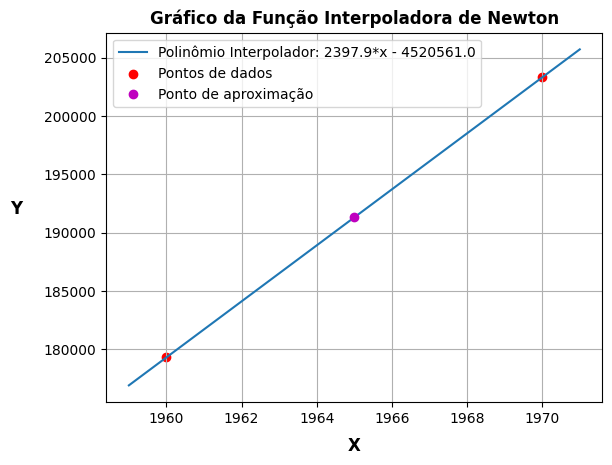

1)......TABELA DE DADOS......:
  x = 1960.000000; f(x) = 179323.000000
  x = 1970.000000; f(x) = 203302.000000

2)......MATRIZ DE VANDERMONDE DO SISTEMA DE EQUAÇÃO......:
  1.000000	  1960.000000	
  1.000000	  1970.000000	

3)......COEFICIENTES DO POLINÔMIO INTERPOLADOR - VANDERMONDE......:
  a0 = -4520561.000000
  a1 = 2397.900000

4)......POLINÔMIO INTERPOLADOR POR SISTEMA DE EQUAÇÃO......:
2397.9*x - 4520561.0

5)......VALOR APROXIMADO......:
  b) O valor aproximado em x = "1965.000000" por Vandermonde é: 191312.500000

*****************FIM DO MÉTODO DE VANDERMONDE*****************



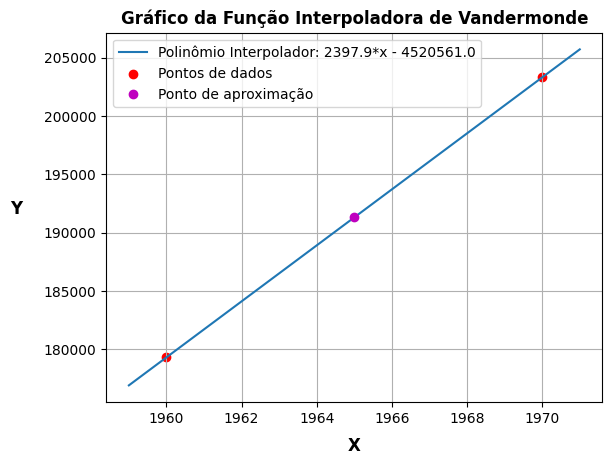

1)......TABELA DE DADOS......:
x = 1960; f(x) = 179323
x = 1970; f(x) = 203302

2)......COEFICIENTES DE LAGRANGE......:
L0(x) = 197 - 0.1x^1
L1(x) = -196 + 0.1x^1

3)......POLINÔMIO INTERPOLADOR POR LAGRANGE......:
2397.9*x - 4520561.0

4)......VALORES EXATO, APROX e ERRO RELATIVO......:
a) Nao temos o valor exato para descobrirmos o valor exato
b) O valor aproximado em x = "1965.000000" por Lagrange é: 191312.500000
c) Nao temos o valor exato para descobrirmos o erro

5)......ESTIMATIVA DO ERRO DE TRUNCAMENTO......:
a) Nao temos a funcao original para descobrirmos o erro

**********FIM DO MÉTODO DE LAGRANGE**********



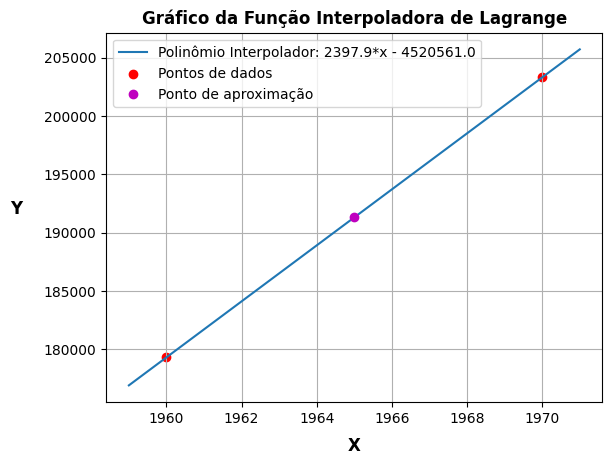

**********INTERPOLAÇÃO: MÉTODO DE NEWTON**********

1)................TABELA DE DADOS................:
  x = 1960.000000; f(x) = 179323.000000
  x = 1970.000000; f(x) = 203302.000000
  x = 1980.000000; f(x) = 226542.000000

2)................TABELA DE DIFERENÇAS DIVIDIDAS................:
Ordem 0	Ordem 1	Ordem 2	
179323.000000	2397.900000	-3.695000	
203302.000000	2324.000000	0.000000	
226542.000000	0.000000	0.000000	

3)................POLINÔMIO INTERPOLADOR POR NEWTON................:
-3.695*x**2 + 16919.25*x - 18787695.0

4)................VALOR APROXIMADO................:
  a) O valor aproximado em x = "1965.000000" por Newton é: 191404.875000

**********FIM DO MÉTODO DE NEWTON**********



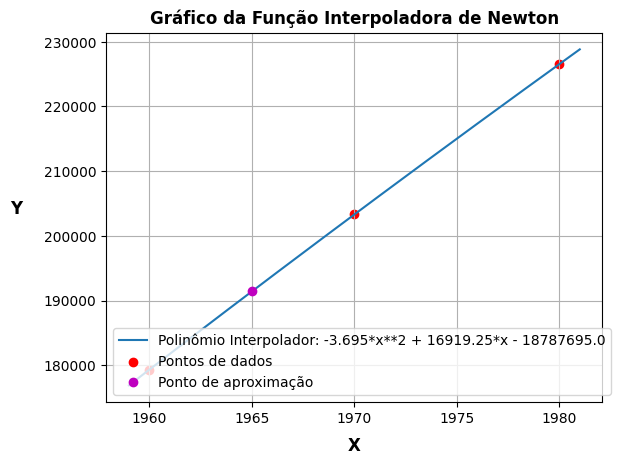

1)......TABELA DE DADOS......:
  x = 1960.000000; f(x) = 179323.000000
  x = 1970.000000; f(x) = 203302.000000
  x = 1980.000000; f(x) = 226542.000000

2)......MATRIZ DE VANDERMONDE DO SISTEMA DE EQUAÇÃO......:
  1.000000	  1960.000000	  3841600.000000	
  1.000000	  1970.000000	  3880900.000000	
  1.000000	  1980.000000	  3920400.000000	

3)......COEFICIENTES DO POLINÔMIO INTERPOLADOR - VANDERMONDE......:
  a0 = -18787695.000000
  a1 = 16919.250000
  a2 = -3.695000

4)......POLINÔMIO INTERPOLADOR POR SISTEMA DE EQUAÇÃO......:
-3.695*x**2 + 16919.25*x - 18787695.0

5)......VALOR APROXIMADO......:
  b) O valor aproximado em x = "1965.000000" por Vandermonde é: 191404.875000

*****************FIM DO MÉTODO DE VANDERMONDE*****************



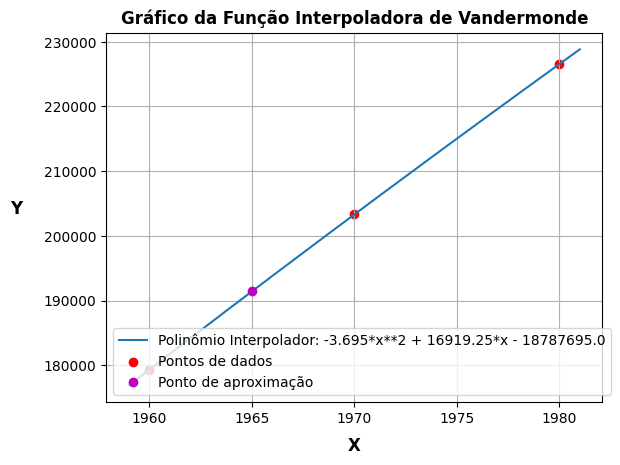

1)......TABELA DE DADOS......:
x = 1960; f(x) = 179323
x = 1970; f(x) = 203302
x = 1980; f(x) = 226542

2)......COEFICIENTES DE LAGRANGE......:
L0(x) = 19503 - 19.75x^1 + 0.005x^2
L1(x) = -38808 + 39.4x^1 - 0.01x^2
L2(x) = 19306 - 19.65x^1 + 0.005x^2

3)......POLINÔMIO INTERPOLADOR POR LAGRANGE......:
-3.69499999999994*x**2 + 16919.2499999991*x - 18787695.0

4)......VALORES EXATO, APROX e ERRO RELATIVO......:
a) Nao temos o valor exato para descobrirmos o valor exato
b) O valor aproximado em x = "1965.000000" por Lagrange é: 191404.874998
c) Nao temos o valor exato para descobrirmos o erro

5)......ESTIMATIVA DO ERRO DE TRUNCAMENTO......:
a) Nao temos a funcao original para descobrirmos o erro

**********FIM DO MÉTODO DE LAGRANGE**********



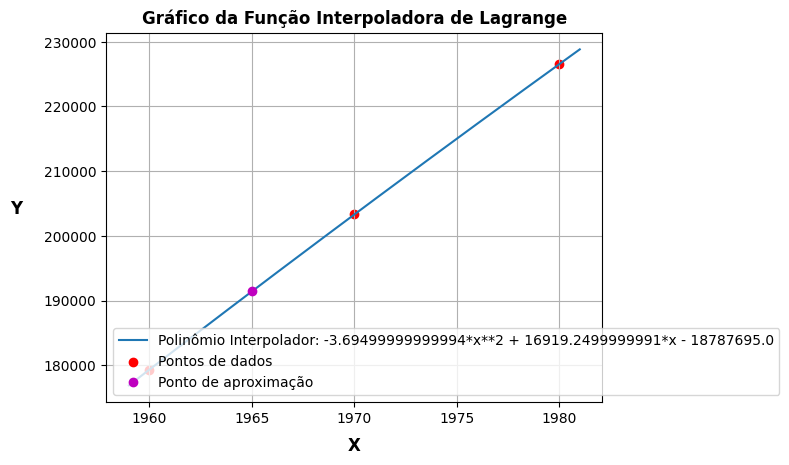

In [17]:
x = [1940, 1950, 1960, 1970, 1980]
y = [132165, 151326, 179323, 203302, 226542]

x_linear = [1960, 1970]
y_linear = [179323, 203302]

x_quadratico = [1960, 1970, 1980]
y_quadratico = [179323, 203302, 226542]

ponto = 1965

# LINEAR
newton(x_linear, y_linear, x, y, ponto)
vandermonde(x_linear, y_linear, ponto)
lagrange(x_linear, y_linear, ponto)

# QUADRÁTICA
newton(x_quadratico, y_quadratico, x, y, ponto)
vandermonde(x_quadratico, y_quadratico, ponto)
lagrange(x_quadratico, y_quadratico, ponto)


## Exercício 2

**********INTERPOLAÇÃO: MÉTODO DE NEWTON**********

1)................TABELA DE DADOS................:
  x = 2000.000000; f(x) = 14.920000
  x = 2010.000000; f(x) = 18.220000

2)................TABELA DE DIFERENÇAS DIVIDIDAS................:
Ordem 0	Ordem 1	
14.920000	0.330000	
18.220000	0.000000	

3)................POLINÔMIO INTERPOLADOR POR NEWTON................:
0.33*x - 645.08

4)................VALORES EXATO, APROX. e ERRO RELATIVO................:
  a) O valor exato em x = "2005.000000" é: 16.487213
  b) O valor aproximado em x = "2005.000000" por Newton é: 16.570000
  c) Er_Rel, |(16.487213 - 16.570000)/16.487213|*100%, é: 0.502130%

5)................ESTIMATIVA DO ERRO DE TRUNCAMENTO................:
  O erro de truncamento pelo corolário 4.1 é: 0.000000
  O erro de truncamento pelo corolário 4.2 é: 0.087500

**********FIM DO MÉTODO DE NEWTON**********



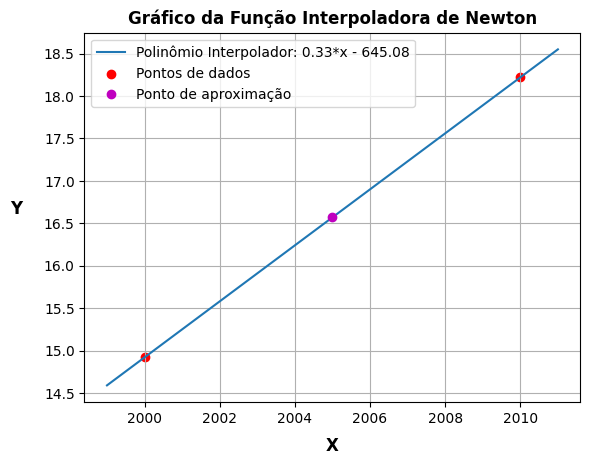

1)......TABELA DE DADOS......:
  x = 2000.000000; f(x) = 14.920000
  x = 2010.000000; f(x) = 18.220000

2)......MATRIZ DE VANDERMONDE DO SISTEMA DE EQUAÇÃO......:
  1.000000	  2000.000000	
  1.000000	  2010.000000	

3)......COEFICIENTES DO POLINÔMIO INTERPOLADOR - VANDERMONDE......:
  a0 = -645.080000
  a1 = 0.330000

4)......POLINÔMIO INTERPOLADOR POR SISTEMA DE EQUAÇÃO......:
0.33*x - 645.08

5)......VALORES EXATO, APROX. e ERRO RELATIVO......:
  a) O valor exato em x = "2005.000000" é: 16.487213
  b) O valor aproximado em x = "2005.000000" por Vandermonde é: 16.570000
  c) O Er_Rel, |(16.487213 - 16.570000) / 16.487213| * 100% é: 0.502130%

6)......ESTIMATIVA DO ERRO DE TRUNCAMENTO......:
  O erro de truncamento pelo corolario 4.1 é: 0.000000

*****************FIM DO MÉTODO DE VANDERMONDE*****************



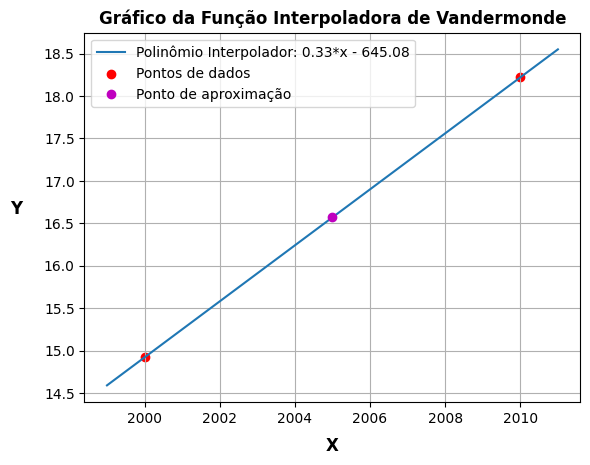

1)......TABELA DE DADOS......:
x = 2000; f(x) = 14.92
x = 2010; f(x) = 18.22

2)......COEFICIENTES DE LAGRANGE......:
L0(x) = 201 - 0.1x^1
L1(x) = -200 + 0.1x^1

3)......POLINÔMIO INTERPOLADOR POR LAGRANGE......:
0.33*x - 645.08

4)......VALORES EXATO, APROX e ERRO RELATIVO......:
a) O valor exato em x = "2005.000000" é: 16.487213
b) O valor aproximado em x = "2005.000000" por Lagrange é: 16.570000
c) O Er_Rel, |16.487213 - 16.570000| / 16.487213| * 100% é -0.502130%

5)......ESTIMATIVA DO ERRO DE TRUNCAMENTO......:
O erro de truncamento pelo corolário 4.1 é 0.000000

**********FIM DO MÉTODO DE LAGRANGE**********



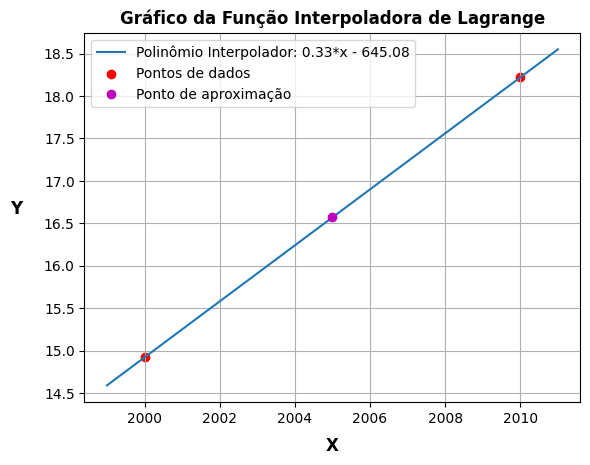

**********INTERPOLAÇÃO: MÉTODO DE NEWTON**********

1)................TABELA DE DADOS................:
  x = 2000.000000; f(x) = 14.920000
  x = 2010.000000; f(x) = 18.220000
  x = 2020.000000; f(x) = 22.260000

2)................TABELA DE DIFERENÇAS DIVIDIDAS................:
Ordem 0	Ordem 1	Ordem 2	
14.920000	0.330000	0.003700	
18.220000	0.404000	0.000000	
22.260000	0.000000	0.000000	

3)................POLINÔMIO INTERPOLADOR POR NEWTON................:
0.0037*x**2 - 14.507*x + 14228.92

4)................VALORES EXATO, APROX. e ERRO RELATIVO................:
  a) O valor exato em x = "2005.000000" é: 16.487213
  b) O valor aproximado em x = "2005.000000" por Newton é: 16.477500
  c) Er_Rel, |(16.487213 - 16.477500)/16.487213|*100%, é: 0.058911%

5)................ESTIMATIVA DO ERRO DE TRUNCAMENTO................:
  O erro de truncamento pelo corolário 4.1 é: 0.000000
  O erro de truncamento pelo corolário 4.2 é: 0.009375

**********FIM DO MÉTODO DE NEWTON**********



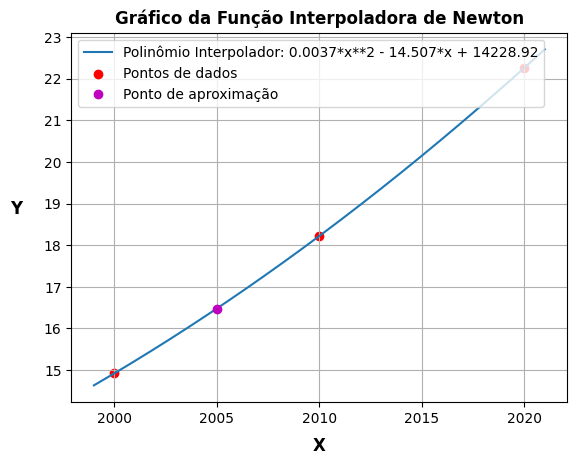

1)......TABELA DE DADOS......:
  x = 2000.000000; f(x) = 14.920000
  x = 2010.000000; f(x) = 18.220000
  x = 2020.000000; f(x) = 22.260000

2)......MATRIZ DE VANDERMONDE DO SISTEMA DE EQUAÇÃO......:
  1.000000	  2000.000000	  4000000.000000	
  1.000000	  2010.000000	  4040100.000000	
  1.000000	  2020.000000	  4080400.000000	

3)......COEFICIENTES DO POLINÔMIO INTERPOLADOR - VANDERMONDE......:
  a0 = 14228.920000
  a1 = -14.507000
  a2 = 0.003700

4)......POLINÔMIO INTERPOLADOR POR SISTEMA DE EQUAÇÃO......:
0.00370000000000002*x**2 - 14.5070000000001*x + 14228.9200000001

5)......VALORES EXATO, APROX. e ERRO RELATIVO......:
  a) O valor exato em x = "2005.000000" é: 16.487213
  b) O valor aproximado em x = "2005.000000" por Vandermonde é: 16.477500
  c) O Er_Rel, |(16.487213 - 16.477500) / 16.487213| * 100% é: 0.058911%

6)......ESTIMATIVA DO ERRO DE TRUNCAMENTO......:
  O erro de truncamento pelo corolario 4.1 é: 0.000000

*****************FIM DO MÉTODO DE VANDERMONDE*****************

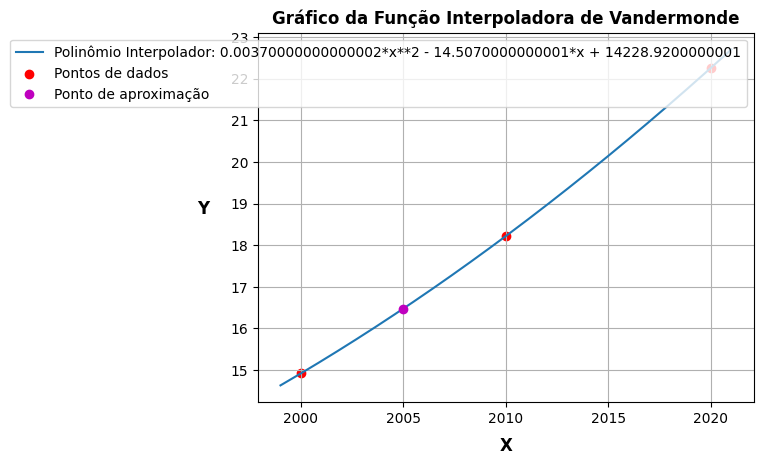

1)......TABELA DE DADOS......:
x = 2000; f(x) = 14.92
x = 2010; f(x) = 18.22
x = 2020; f(x) = 22.26

2)......COEFICIENTES DE LAGRANGE......:
L0(x) = 20301 - 20.15x^1 + 0.005x^2
L1(x) = -40400 + 40.2x^1 - 0.01x^2
L2(x) = 20100 - 20.05x^1 + 0.005x^2

3)......POLINÔMIO INTERPOLADOR POR LAGRANGE......:
0.00370000000000001*x**2 - 14.5070000000001*x + 14228.92

4)......VALORES EXATO, APROX e ERRO RELATIVO......:
a) O valor exato em x = "2005.000000" é: 16.487213
b) O valor aproximado em x = "2005.000000" por Lagrange é: 16.477500
c) O Er_Rel, |16.487213 - 16.477500| / 16.487213| * 100% é 0.058911%

5)......ESTIMATIVA DO ERRO DE TRUNCAMENTO......:
O erro de truncamento pelo corolário 4.1 é 0.000000

**********FIM DO MÉTODO DE LAGRANGE**********



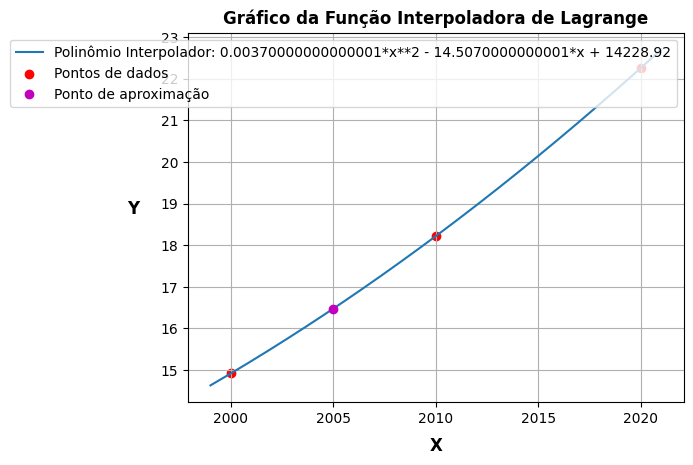

In [25]:
x = [1980, 1990, 2000, 2010, 2020]
y = [10.20, 12.21, 14.92, 18.22, 22.26]

x_linear = [2000, 2010]
y_linear = [14.92, 18.22]

x_quadratico = [2000, 2010, 2020]
y_quadratico = [14.92, 18.22, 22.26]

ponto = 2005

xsim = sp.symbols('x')

funcao = 10 * sp.exp(0.02*25)
derivada_linear = sp.diff(funcao, xsim, 2)
derivada_quadratica = sp.diff(funcao, xsim, 3)

# LINEAR
newton(x_linear, y_linear, x, y, ponto, funcao, derivada_linear)
vandermonde(x_linear, y_linear, ponto, funcao, derivada_linear)
lagrange(x_linear, y_linear, ponto, funcao, derivada_linear)

# QUADRATICO
newton(x_quadratico, y_quadratico, x, y, ponto, funcao, derivada_quadratica)
vandermonde(x_quadratico, y_quadratico, ponto, funcao, derivada_quadratica)
lagrange(x_quadratico, y_quadratico, ponto, funcao, derivada_quadratica)

# 3, 4 - AJUSTE DE FUNCÃO

## Exercício 3

1)......TABELA DE DADOS......:
  x = -50.000000; f(x) = 0.125000
  x = -20.000000; f(x) = 0.128000

2)......MATRIZ DE VANDERMONDE DO SISTEMA DE EQUAÇÃO......:
  1.000000	  -50.000000	
  1.000000	  -20.000000	

3)......COEFICIENTES DO POLINÔMIO INTERPOLADOR - VANDERMONDE......:
  a0 = 0.130000
  a1 = 0.000100

4)......POLINÔMIO INTERPOLADOR POR SISTEMA DE EQUAÇÃO......:
0.0001*x + 0.13

5)......VALOR APROXIMADO......:
  b) O valor aproximado em x = "-35.000000" por Vandermonde é: 0.126500

*****************FIM DO MÉTODO DE VANDERMONDE*****************



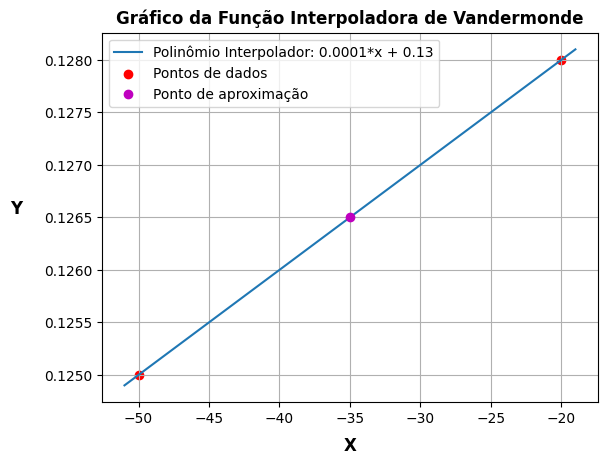

1)......TABELA DE DADOS......:
  x = -50.000000; f(x) = 0.125000
  x = -20.000000; f(x) = 0.128000
  x = 10.000000; f(x) = 0.134000

2)......MATRIZ DE VANDERMONDE DO SISTEMA DE EQUAÇÃO......:
  1.000000	  -50.000000	  2500.000000	
  1.000000	  -20.000000	  400.000000	
  1.000000	  10.000000	  100.000000	

3)......COEFICIENTES DO POLINÔMIO INTERPOLADOR - VANDERMONDE......:
  a0 = 0.131667
  a1 = 0.000217
  a2 = 0.000002

4)......POLINÔMIO INTERPOLADOR POR SISTEMA DE EQUAÇÃO......:
1.66666666666667e-6*x**2 + 0.000216666666666667*x + 0.131666666666667

5)......VALOR APROXIMADO......:
  b) O valor aproximado em x = "-35.000000" por Vandermonde é: 0.126125

*****************FIM DO MÉTODO DE VANDERMONDE*****************



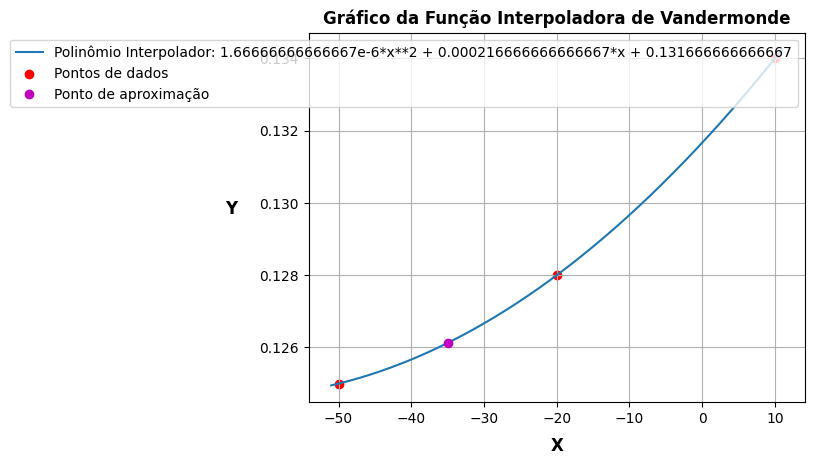

/////////////// AJUSTE POR REGRESSÃO POLINOMIAL-MÉTODO QUADRADOS MÍNIMOS ///////////////
/////////////////////////// TABELA DE DADOS PARA OS AJUSTES: ///////////////////////////
  x = -50.000000        y(x) = 0.125000
  x = -35.000000        y(x) = 0.126000
  x = -20.000000        y(x) = 0.128000
  x = 10.000000        y(x) = 0.134000
  x = 70.000000        y(x) = 0.144000
  x = 100.000000        y(x) = 0.150000
  x = 120.000000        y(x) = 0.155000

**************************  REGRESSÃO LINEAR  **************************
///////// MATRIZ DO SISTEMA LINEAR PARA CALCULAR OS COEFICIENTES ////////
7.00 195.00
195.00 33525.00

//////////////////// VETOR DOS TERMOS INDEPENDENTES /////////////////////
0.96
31.80

A equação linear da reta é = 0.132469 + 0.000178037x
//////////////////////// SOMA DOS DESVIOS QUADRÁTICOS ////////////////////////
0.0000

////////////////////// COEFICIENTE DE DETERMINAÇÃO R^2 //////////////////////
0.9941

**************************  REGRESSÃO QUADRATICA  *****

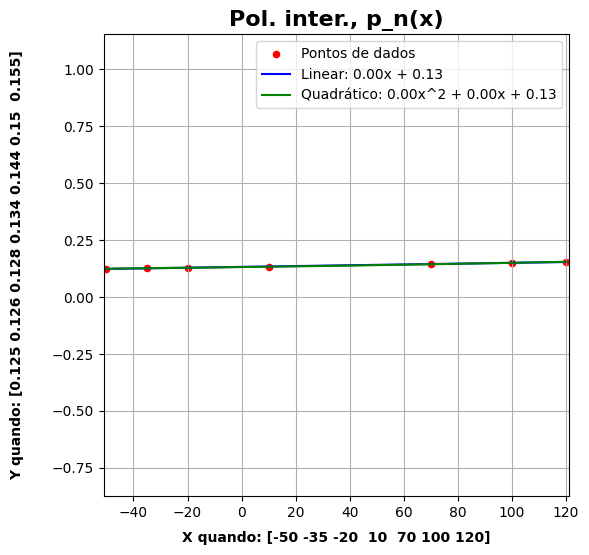

In [29]:
# Aproximação
x_linear = [-50, -20]
y_linear = [0.125, 0.128]

x_quadratico = [-50, -20, 10]
y_quadratico = [0.125, 0.128, 0.134]

ponto = -35
# LINEAR
vandermonde(x_linear, y_linear, ponto)

# QUADRÁTICO
vandermonde(x_quadratico, y_quadratico, ponto)

# Regressão
x = np.array([-50, -35, -20, 10, 70, 100, 120])
y = np.array([0.125, 0.126, 0.128, 0.134, 0.144, 0.150, 0.155])

ajuste_polinomial(x, y, 1, grau=2)

## Exercício 4

1)......TABELA DE DADOS......:
  x = 50.000000; f(x) = 52.000000
  x = 70.000000; f(x) = 65.000000

2)......MATRIZ DE VANDERMONDE DO SISTEMA DE EQUAÇÃO......:
  1.000000	  50.000000	
  1.000000	  70.000000	

3)......COEFICIENTES DO POLINÔMIO INTERPOLADOR - VANDERMONDE......:
  a0 = 19.500000
  a1 = 0.650000

4)......POLINÔMIO INTERPOLADOR POR SISTEMA DE EQUAÇÃO......:
0.65*x + 19.5

5)......VALOR APROXIMADO......:
  b) O valor aproximado em x = "60.000000" por Vandermonde é: 58.500000

*****************FIM DO MÉTODO DE VANDERMONDE*****************



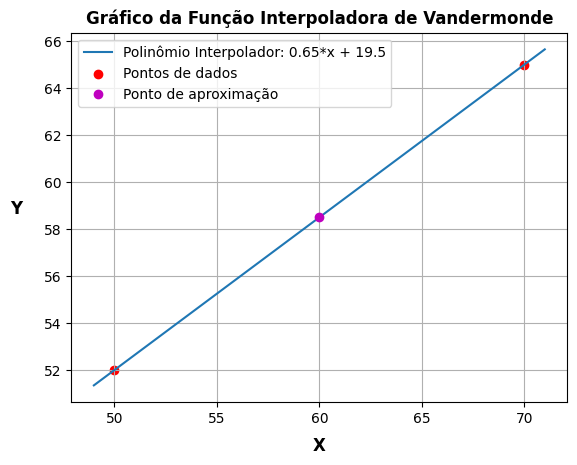

1)......TABELA DE DADOS......:
  x = 40.000000; f(x) = 39.000000
  x = 50.000000; f(x) = 52.000000
  x = 70.000000; f(x) = 65.000000

2)......MATRIZ DE VANDERMONDE DO SISTEMA DE EQUAÇÃO......:
  1.000000	  40.000000	  1600.000000	
  1.000000	  50.000000	  2500.000000	
  1.000000	  70.000000	  4900.000000	

3)......COEFICIENTES DO POLINÔMIO INTERPOLADOR - VANDERMONDE......:
  a0 = -56.333333
  a1 = 3.250000
  a2 = -0.021667

4)......POLINÔMIO INTERPOLADOR POR SISTEMA DE EQUAÇÃO......:
-0.0216666666666667*x**2 + 3.25*x - 56.3333333333333

5)......VALOR APROXIMADO......:
  b) O valor aproximado em x = "60.000000" por Vandermonde é: 60.666667

*****************FIM DO MÉTODO DE VANDERMONDE*****************



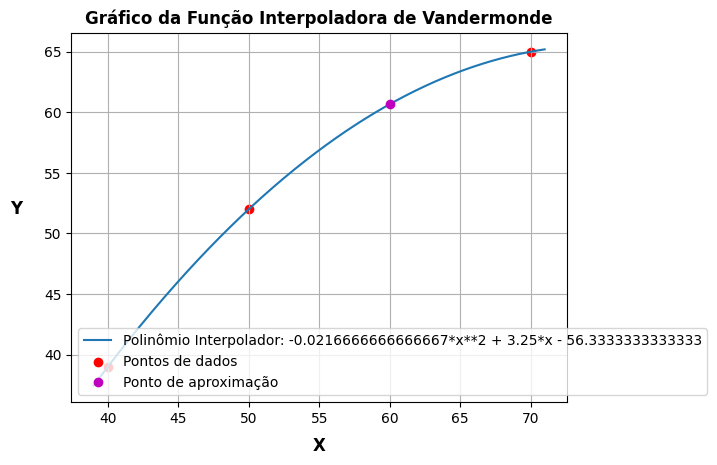

/////////////// AJUSTE POR REGRESSÃO POLINOMIAL-MÉTODO QUADRADOS MÍNIMOS ///////////////
/////////////////////////// TABELA DE DADOS PARA OS AJUSTES: ///////////////////////////
  x = 0.000000        y(x) = 0.000000
  x = 10.000000        y(x) = 10.000000
  x = 20.000000        y(x) = 19.000000
  x = 30.000000        y(x) = 31.000000
  x = 40.000000        y(x) = 39.000000
  x = 50.000000        y(x) = 52.000000
  x = 60.000000        y(x) = 58.500000
  x = 70.000000        y(x) = 65.000000
  x = 80.000000        y(x) = 69.000000
  x = 90.000000        y(x) = 70.000000

**************************  REGRESSÃO LINEAR  **************************
///////// MATRIZ DO SISTEMA LINEAR PARA CALCULAR OS COEFICIENTES ////////
10.00 450.00
450.00 28500.00

//////////////////// VETOR DOS TERMOS INDEPENDENTES /////////////////////
413.50
25450.00

A equação linear da reta é = 4.02727 + 0.829394x
//////////////////////// SOMA DOS DESVIOS QUADRÁTICOS ////////////////////////
181.8970

/////////////////

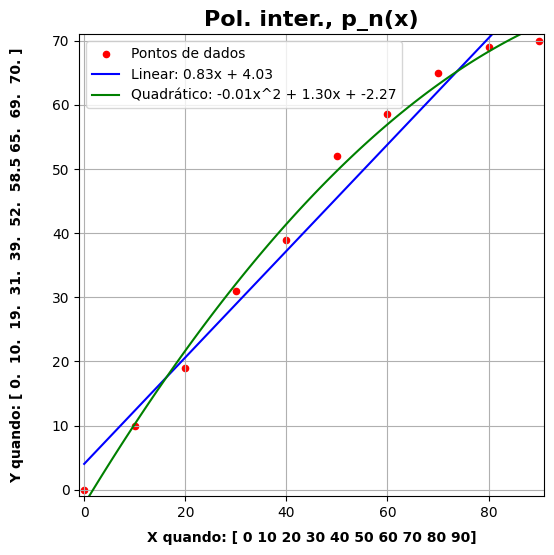

In [32]:
# Aproximação
x_linear = [50, 70]
y_linear = [52, 65]

x_quadratico = [40, 50, 70]
y_quadratico = [39, 52, 65]

ponto = 60

vandermonde(x_linear, y_linear, ponto)
vandermonde(x_quadratico, y_quadratico, ponto)

# Regressão
x = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
y = np.array([0, 10, 19, 31, 39, 52, 58.50, 65, 69, 70])

ajuste_polinomial(x, y, 1, grau=2)

# 5, 6 - DERIVADAS NUMÉRICAS

## Exercício 5

In [21]:
# Dados da tabela
xk = np.array([3, 4, 5, 6, 7, 8])
fx = np.array([1.0986, 1.3862, 1.6094, 1.7917, 1.9459, 2.0794])
a = 5
b = 6

x = sp.symbols('x')
# função que é dada pelo exercicio
f = sp.log(x)

# Calculando as derivadas aproximadas
print("********SÉRIE DE TAYLOR E DIFERENÇAS FINITAS: PONTO = 5********")
derivada_taylor(xk, fx, 1, a, f)
derivada_taylor(xk, fx, 2, a, f)
derivada_taylor(xk, fx, 3, a, f)
derivada_taylor(xk, fx, 4, a, f)
print("******FIM DA SÉRIE DE TAYLOR E DIFERENÇAS FINITAS******\n")

print("********DIFERENCIAÇÃO METÓDO DE LAGRANGE: PONTO = 5********")
derivada_lagrange(xk, fx, 1, a, f)
derivada_lagrange(xk, fx, 2, a, f)
derivada_lagrange(xk, fx, 3, a, f)
print("******FIM DE DIFERENCIAÇÃO METÓDO DE LAGRANGE******\n")

# Calculando as derivadas aproximadas
print("********SÉRIE DE TAYLOR E DIFERENÇAS FINITAS: PONTO = 6********")
derivada_taylor(xk, fx, 1, b, f)
derivada_taylor(xk, fx, 2, b, f)
derivada_taylor(xk, fx, 3, b, f)
derivada_taylor(xk, fx, 4, b, f)
print("******FIM DA SÉRIE DE TAYLOR E DIFERENÇAS FINITAS******\n")

print("********DIFERENCIAÇÃO METÓDO DE LAGRANGE: PONTO = 6********")
derivada_lagrange(xk, fx, 1, b, f)
derivada_lagrange(xk, fx, 2, b, f)
derivada_lagrange(xk, fx, 3, b, f)
print("******FIM DE DIFERENCIAÇÃO METÓDO DE LAGRANGE******\n")

********SÉRIE DE TAYLOR E DIFERENÇAS FINITAS: PONTO = 5********
Calculando f'(5) pelo MDF-Progressiva de 1ª Ordem:
f'(xk) ~ (f(xk+1) - f(xk)) / h1
       ~ (f(6) - f(5)) / 1.000000
       ~ (1.791700 - 1.609400) / 1.000000
       ~ 0.182300

Er_rel = | (0.200000 - 0.182300) / 0.200000 | * 100% = 8.850000%
Er_Trunc = | (1.000000/2)*-0.040000 | = 0.020000

Calculando f'(5) pelo MDF-Regressiva de 1ª Ordem:
f'(xk) ~ (f(xk) - f(xk-1)) / h2
       ~ (f(5) - f(4)) / 1.000000
       ~ (1.609400 - 1.386200) / 1.000000
       ~ 0.223200

Er_rel = | (0.200000 - 0.223200) / 0.200000 | * 100% = 11.600000%
Er_Trunc = | (1.000000/2)*-0.040000 | = 0.020000

Calculando f'(5) pelo MDF-Centrada de 2ª Ordem à primeira derivda: 
f'(xk) ~ (f(xk+1) - f(xk-1)) / h3
       ~ (f(6) - f(4)) / 2.000000
       ~ (1.791700 - 1.386200) / 2.000000
       ~ 0.202750

Er_rel = | (0.200000 - 0.202750) / 0.200000 | * 100% = 1.375000%
Er_Trunc = | (2.000000^2 / 6) * 0.016000 | = 0.010667

Calculando f'(5) pelo MDF-Centrad

## Exercício 6

In [22]:
# Dados da tabela
xk = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7])
fx = np.array([11.59, 14.04, 16.86, 20.10, 23.80, 28.05])
a = 1.4

x = sp.symbols('x')
# função que é dada pelo exercicio
f = 3 * x * sp.exp(x) - sp.cos(x)

# Calculando as derivadas aproximadas
print("********SÉRIE DE TAYLOR E DIFERENÇAS FINITAS********")
derivada_taylor(xk, fx, 1, a, f)
derivada_taylor(xk, fx, 2, a, f)
derivada_taylor(xk, fx, 3, a, f)
derivada_taylor(xk, fx, 4, a, f)
print("******FIM DA SÉRIE DE TAYLOR E DIFERENÇAS FINITAS******\n")

print("********DIFERENCIAÇÃO METÓDO DE LAGRANGE********")
derivada_lagrange(xk, fx, 1, a, f)
derivada_lagrange(xk, fx, 2, a, f)
derivada_lagrange(xk, fx, 3, a, f)
print("******FIM DE DIFERENCIAÇÃO METÓDO DE LAGRANGE******\n")

********SÉRIE DE TAYLOR E DIFERENÇAS FINITAS********
Calculando f'(1.4) pelo MDF-Progressiva de 1ª Ordem:
f'(xk) ~ (f(xk+1) - f(xk)) / h1
       ~ (f(1.5) - f(1.4)) / 0.100000
       ~ (20.100000 - 16.860000) / 0.100000
       ~ 32.400000

Er_rel = | (30.182889 - 32.400000) / 30.182889 | * 100% = 7.345587%
Er_Trunc = | (0.100000/2)*41.533007 | = 2.076650

Calculando f'(1.4) pelo MDF-Regressiva de 1ª Ordem:
f'(xk) ~ (f(xk) - f(xk-1)) / h2
       ~ (f(1.4) - f(1.3)) / 0.100000
       ~ (16.860000 - 14.040000) / 0.100000
       ~ 28.200000

Er_rel = | (30.182889 - 28.200000) / 30.182889 | * 100% = 6.569581%
Er_Trunc = | (0.100000/2)*41.533007 | = 2.076650

Calculando f'(1.4) pelo MDF-Centrada de 2ª Ordem à primeira derivda: 
f'(xk) ~ (f(xk+1) - f(xk-1)) / h3
       ~ (f(1.5) - f(1.3)) / 0.200000
       ~ (20.100000 - 14.040000) / 0.200000
       ~ 30.300000

Er_rel = | (30.182889 - 30.300000) / 30.182889 | * 100% = 0.388003%
Er_Trunc = | (0.200000^2 / 6) * 52.543190 | = 0.350288

Calculan